# What We’re Doing  
Hi!  
In this notebook I’m running an  experiment: I take two versions of the XGBoost model —  
one with default settings and another with “heavy” hyper-parameters borrowed from a public Kaggle notebook.  
For each model I create a logging function: every run saves its result into a DataFrame. So I get two initial  
baseline results.  
Then — features: I intend to create a large number of features (~60), often redundant, record the models’  
metrics after each change, and then enter a phase of removing “toxic” features. First based on the reaction  
of the default model, then I’ll check how the tuned version reacts.  
The question I want to explore: will the models move in sync with feature changes or will they show different  
signals — which features look useful for the advanced model but useless or harmful for the simple one.  
I’ll also use an auxiliary function for binning and frequency‐transformation of features (thanks to the author  
of the code — I’ll include a link).  
**Summary**: two models → logging metrics → many features → step-by-step feature removal → model  
reaction comparison. Hope it will be interesting and useful.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn import metrics

from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

pd.set_option('display.max_columns', None)

In [ ]:
pip install --upgrade xgboost scikit-learn

In [ ]:
df=pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
X_test=pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
X=df.copy()
y=X.pop('accident_risk')

target = df.columns.tolist()[-1]

In [ ]:
# creating Score table to compare scores
Scoresy=pd.DataFrame()
Scoresy['experiment_name'] = pd.Series()

## Defining two helper functions: first for scoring, and second for saving score to table
def get_scored(X,y):    
    model = XGBRegressor(enable_categorical=True,) #tree_method='hist', device='cuda')
    score = cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error')
    print(f'RMSE on 5 folds {np.sqrt(-1*score.mean())}')
    return score

def save_score(score, Scoresy, name):
    Scoresy = pd.concat([Scoresy, pd.DataFrame(np.sqrt(-1*score)).T],ignore_index=True)
    Scoresy['mean']= Scoresy[[0,1,2,3,4]].mean(axis=1)
    Scoresy['std'] = Scoresy[[0,1,2,3,4]].std(axis=1)
    Scoresy.iloc[-1, 0]=name
    return Scoresy

In [ ]:
## Defining two helper functions: first for scoring, and second for saving score to table
Scoresy_m2 = pd.DataFrame()

def add_row(df, **kwargs):
    new_row = pd.DataFrame([kwargs])
    return pd.concat([df, new_row], ignore_index=True)

def get_scored_m2(X,y):
    # Prepare DMatrix for XGBoost since i'm going to use .cv()
    dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

    xgb_params = {
        'max_depth': 11, 'learning_rate': 0.011,
        'subsample': 0.8, 'colsample_bytree': 0.82,
        'min_child_weight': 3, 'gamma': 0.011,
        'reg_alpha': 0.12, 'reg_lambda': 0.4,
        'max_delta_step': 1, 'colsample_bylevel': 0.86,
        'colsample_bynode': 0.88, 'scale_pos_weight': 0.36,
        'max_bin': 512, 'tree_method': 'hist', "device":"cuda",
        'eval_metric': 'rmse', 'random_state': 42,
    }
    
    # Run cross-validation
    cv_results = xgb.cv(
        params=xgb_params,
        dtrain=dtrain,
        nfold=5,
        num_boost_round=2000,
        metrics='rmse',
        verbose_eval=100,
        early_stopping_rounds=50
    )
    
    print(cv_results.tail())
    
    # Extract best boosting round
    best_round = cv_results['test-rmse-mean'].idxmin()
    best_rmse = cv_results['test-rmse-mean'][best_round]
    print(f"Best round: {best_round}, Best CV RMSE: {best_rmse:.7f}")
    return best_rmse, best_round, cv_results

In [ ]:
# turning 'objects' dtype to 'category'
for col in X.columns:
    if X[col].dtype == 'object':
         X[col] = X[col].astype('category')

## Just Baseline

In [ ]:
X.info()

In [42]:
# 'Heavy weighted Baaseline'
best_rmse, best_round, cv_result =  get_scored_m2(X,y)
Scoresy_m2 = add_row(Scoresy_m2, name='baseline', best_round=best_round, best_rmse=best_rmse)
Scoresy_m2

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:53:48] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:53:49] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [09:53:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[0]	train-rmse:0.16533+0.00007	test-rmse:0.16534+0.00027
[100]	train-rmse:0.08720+0.00038	test-rmse:0.08773+0.00049
[200]	train-rmse:0.06213+0.00027	test-rmse:0.06306+0.00038
[300]	train-rmse:0.05640+0.00011	test-rmse:0.05751+0.00019
[400]	train-rmse:0.05516+0.00004	test-rmse:0.05635+0.00018
[500]	train-rmse:0.05487+0.00003	test-rmse:0.05610+0.00018
[600]	train-rmse:0.05478+0.00004	test-rmse:0.05604+0.00018
[700]	train-rmse:0.05475+0.00004	test-rmse:0.05603+0.00018
[800]	train-rmse:0.05473+0.00004	test-rmse:0.05602+0.00018
[900]	train-rmse:0.05473+0.00004	test-rmse:0.05602+0.00018
[1000]	train-rmse:0.05472+0.00004	test-rmse:0.05602+0.00018
[1100]	train-rmse:0.05472+0.00004	test-rmse:0.05602+0.00018
[1200]	train-rmse:0.05472+0.00004	test-rmse:0.05602+0.00018
[1300]	train-rmse:0.05472+0.00004	test-rmse:0.05602+0.00018
[1400]	train-rmse:0.05472+0.00004	test-rmse:0.05602+0.00018
[1500]	train-rmse:0.05472+0.00004	test-rmse:0.05602+0.00018
[1600]	train-rmse:0.05472+0.00004	test-rmse:0.05602+

,name,best_round,best_rmse
0,baseline,1966,0.056015


In [ ]:
# Let's create first light weited Baseline!
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'Baseline')
Scoresy

## Building Intuition

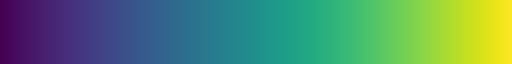

In [45]:
sns.color_palette("viridis", as_cmap=True)

In [46]:
X.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1


In [47]:
df_frac = df.sample(n =20000)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


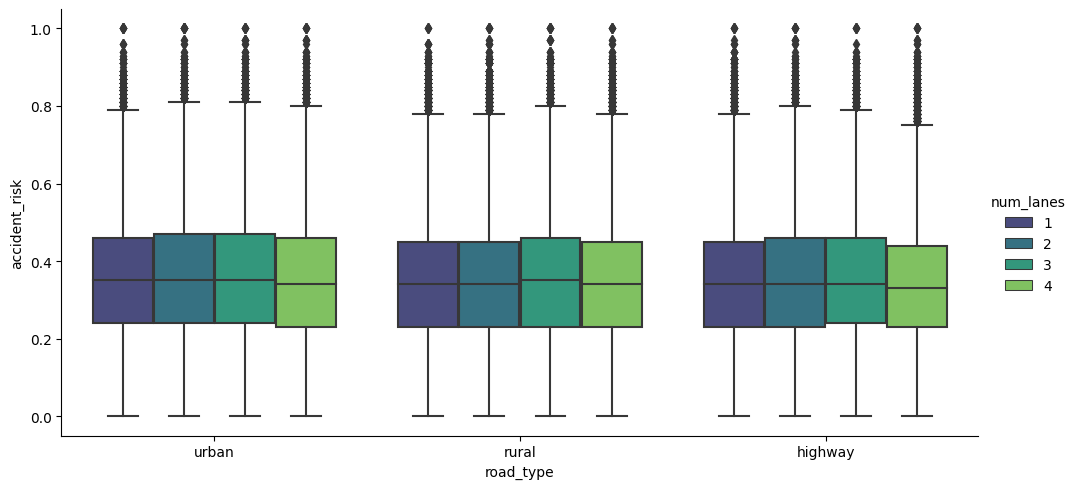

In [48]:
sns.catplot(data = df, x='road_type', y='accident_risk', kind="box",height=5, aspect=2, hue='num_lanes',palette="viridis")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='accident_risk', ylabel='curvature'>

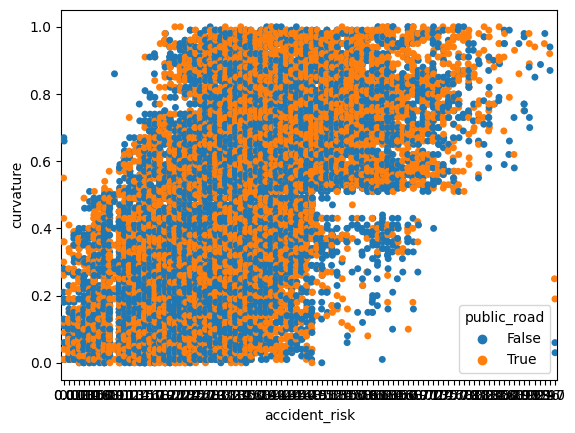

In [49]:
sns.stripplot(data=df_frac, x='accident_risk' ,y='curvature', hue= 'public_road')

<Axes: xlabel='weather', ylabel='accident_risk'>

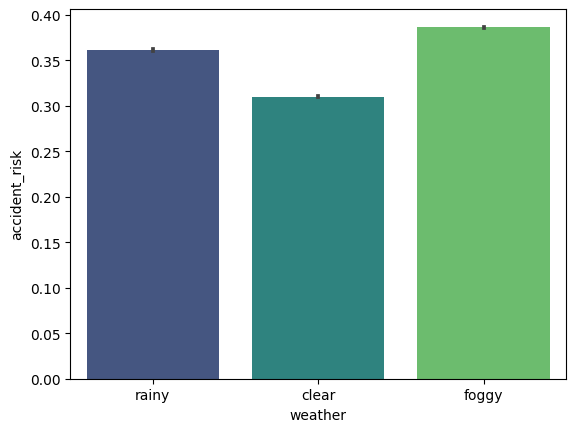

In [50]:
sns.barplot(data = df, y='accident_risk', x='weather', palette="viridis")

<Axes: xlabel='time_of_day', ylabel='accident_risk'>

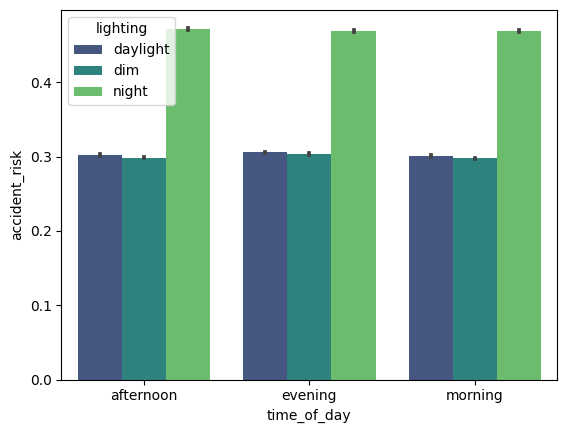

In [51]:
sns.barplot(data = df, y='accident_risk', x='time_of_day',hue='lighting', palette="viridis")

*  that's strnge, but its fine to have 'night' and 'afternoon' in day time, maybe some data are, kind off, gathered from polar reageon with half-year night . LOL maybe, maybe 

In [65]:
X[X['time_of_day']=='afternoon']

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1
9,9,urban,4,0.38,45,dim,clear,True,True,afternoon,True,True,2
10,10,highway,1,0.45,45,dim,clear,False,False,afternoon,True,False,2
15,15,urban,1,0.52,60,daylight,clear,False,True,afternoon,True,False,1
18,18,rural,3,0.72,60,night,foggy,True,True,afternoon,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517748,517748,rural,2,0.53,70,dim,foggy,True,True,afternoon,True,True,2
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3


# Feature engineering

In [66]:
def preprocess_first_round(df):
    df = df.drop(columns=['id'], errors='ignore')
    df['num_lanes_cat']=df['num_lanes']
    df['num_lanes_cat']=df['num_lanes_cat'].astype('category')
    df['weather'] = df['weather'].map({'clear': 0, 'foggy': 1, 'rainy':2})
    df['weather_quality'] = df['weather'].astype(int)
    df['lighting']=df['lighting'].map({'night':0, 'dim':1, 'daylight' : 2})
    df['lighting_quality'] = df['lighting'].astype(int)
    # bool_cats=['road_signs_present','public_road', 'holiday', 'school_season']
    # df[bool_cats] = df[bool_cats] .astype(int)
    
    df['lanes_speed_lightning_feature']=(
        df['num_lanes'].astype(str) + '_' +
        df['speed_limit'].astype(str)  + '_' + 
        df['lighting'].astype(str)
    )
    
    df['lanes_speed_lightning_feature'] = df['lanes_speed_lightning_feature'].astype('category')
    df['speed_curvature_ratio'] = df['curvature']*df['speed_limit']**2
    for col in df.columns:
        if df[col].dtype == 'object':
             df[col] = df[col].astype('category')
    
    return df

In [67]:
X = preprocess_first_round(X)

In [68]:
X_test = preprocess_first_round(X_test)

In [69]:
def create_frequency_features(train_df, test_df, cols, num, cat):
    """
    Add frequency and binning features to the dataset.
    
    - For each column, create <col>_freq = how often each value appears in train data.
    - For numeric columns, split values into 5 and 10 quantile bins (groups) to show rank or range.
    """
    train, test = train_df.copy(), test_df.copy()

    for col in cols:
        # Frequency encoding: how common each value is
        freq = train[col].value_counts(normalize=True)
        train[f"{col}_freq"] = train[col].map(freq).astype('float')
        test[f"{col}_freq"] = test[col].map(freq).astype('float').fillna(train[f"{col}_freq"].mean())

        # Binning: group numeric values into quantiles
        if col in num:
            for q in [5, 10, 15]:
                try:
                    train[f"{col}_bin{q}"], bins = pd.qcut(train[col], q=q, labels=False, retbins=True, duplicates="drop")
                    test[f"{col}_bin{q}"] = pd.cut(test[col], bins=bins, labels=False, include_lowest=True)
                except Exception:
                    train[f"{col}_bin{q}"] = test[f"{col}_bin{q}"] = 0

    new_num = train.drop(columns=cat).columns.tolist()
    return train, test, new_num

In [70]:
# Identify feature
cols = X.columns.tolist()

# Categorical features
cat = [col for col in cols if X[col].dtype in ["object","category"]]

# Numerical features
num = [col for col in cols if X[col].dtype not in ["object","category","bool"]]

# Creating new features based on the frequency of numerical features
X, X_test, new_num = create_frequency_features(X, X_test, cols, num, cat)

In [71]:
# Mapping a column
map_col = "num_reported_accidents"
map_num_reported = {0:0, 1:0, 2:0, 3:2, 4:4, 5:3, 6:1, 7:0}
X[map_col] = X[map_col].map(map_num_reported)
X_test[map_col] = X_test[map_col].map(map_num_reported)

In [72]:
X.drop_duplicates(inplace=True)
y = y.iloc[X.index]

In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506980 entries, 0 to 517753
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   road_type                           506980 non-null  category
 1   num_lanes                           506980 non-null  int64   
 2   curvature                           506980 non-null  float64 
 3   speed_limit                         506980 non-null  int64   
 4   lighting                            506980 non-null  category
 5   weather                             506980 non-null  category
 6   road_signs_present                  506980 non-null  bool    
 7   public_road                         506980 non-null  bool    
 8   time_of_day                         506980 non-null  category
 9   holiday                             506980 non-null  bool    
 10  school_season                       506980 non-null  bool    
 11  num_reported_accid

I found that 'id' column is kind of toxic one

In [74]:
X[cat], X_test[cat] = X[cat].astype("category"), X_test[cat].astype("category")

# Drop out feature experiment

In [75]:
best_rmse, best_round, cv_result =  get_scored_m2(X,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='before_feature_reduction_experement',
    best_round=best_round,
    best_rmse=best_rmse
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:33] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:34] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:35] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:02:36] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[0]	train-rmse:0.16493+0.00006	test-rmse:0.16493+0.00023
[100]	train-rmse:0.07568+0.00002	test-rmse:0.07615+0.00012
[200]	train-rmse:0.05763+0.00004	test-rmse:0.05862+0.00013
[300]	train-rmse:0.05506+0.00005	test-rmse:0.05634+0.00017
[400]	train-rmse:0.05465+0.00005	test-rmse:0.05608+0.00018
[500]	train-rmse:0.05451+0.00005	test-rmse:0.05605+0.00019
[600]	train-rmse:0.05446+0.00004	test-rmse:0.05604+0.00019
[694]	train-rmse:0.05443+0.00005	test-rmse:0.05604+0.00019
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
641         0.054442        0.000045        0.056044       0.000191
642         0.054442        0.000045        0.056044       0.000191
643         0.054441        0.000045        0.056044       0.000191
644         0.054441        0.000045        0.056044       0.000191
645         0.054441        0.000045        0.056044       0.000191
Best round: 645, Best CV RMSE: 0.0560438


In [76]:
Scoresy_m2

,name,best_round,best_rmse
0,before_feature_reduction_experement,645,0.056044


In [77]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'before_feature_reduction_experement')
Scoresy 

RMSE on 5 folds 0.056321934353781314


,experiment_name,0,1,2,3,4,mean,std
0,before_feature_reduction_experement,0.056655,0.055952,0.056466,0.056453,0.056079,0.056321,0.000294


In [78]:
y.shape, X.shape

((506980,), (506980, 55))

In [79]:
toxic=[]
neutral = []

tol = 1e-6 

for f in X.columns:
    X_reduced = X.copy()
    
    X_reduced.pop(f)
    X_reduced.drop(columns=toxic, errors='ignore', inplace=True)
    Score = get_scored(X_reduced,y)
    
    mean_score = np.sqrt(-1*Score.mean())
    best_mean = Scoresy['mean'].min() if not Scoresy.empty else 0
    
    if (best_mean - mean_score) > 1e-6:  
        toxic.append(f)
        print(f'{f} to toxic')
    elif abs(mean_score - best_mean) <= tol:
        toxic.append(f)
        neutral.append(f)
        print(f'{f} to neutral')
    Scoresy = save_score(Score, Scoresy, f'poped_{f}')
    

RMSE on 5 folds 0.056325288758900194
RMSE on 5 folds 0.0563222551427662
num_lanes to neutral
RMSE on 5 folds 0.05636529640418292
RMSE on 5 folds 0.05632250260219936
RMSE on 5 folds 0.05632229890096413
lighting to neutral
RMSE on 5 folds 0.05632292713346455
RMSE on 5 folds 0.05632145125574524
road_signs_present to neutral
RMSE on 5 folds 0.05632145589365081
public_road to neutral
RMSE on 5 folds 0.056319725728120135
time_of_day to toxic
RMSE on 5 folds 0.05631853539429167
holiday to neutral
RMSE on 5 folds 0.05631856395786188
school_season to neutral
RMSE on 5 folds 0.05631806623566525
num_reported_accidents to neutral
RMSE on 5 folds 0.056317966775531865
num_lanes_cat to neutral
RMSE on 5 folds 0.056317966775531865
weather_quality to neutral
RMSE on 5 folds 0.05631866335273731
RMSE on 5 folds 0.05622787587324752
lanes_speed_lightning_feature to toxic
RMSE on 5 folds 0.05623421917908639
RMSE on 5 folds 0.05622787587324752
road_type_freq to neutral
RMSE on 5 folds 0.056227826400527446
nu

In [80]:
print(toxic)

['num_lanes', 'lighting', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'num_lanes_cat', 'weather_quality', 'lanes_speed_lightning_feature', 'road_type_freq', 'num_lanes_freq', 'num_lanes_bin5', 'num_lanes_bin10', 'curvature_bin5', 'curvature_bin10', 'curvature_bin15', 'speed_limit_freq', 'speed_limit_bin5', 'speed_limit_bin10', 'speed_limit_bin15', 'lighting_freq', 'weather_freq', 'num_reported_accidents_bin5', 'num_reported_accidents_bin10', 'num_lanes_cat_freq', 'weather_quality_freq', 'weather_quality_bin5', 'weather_quality_bin10', 'weather_quality_bin15', 'lighting_quality_bin5', 'lighting_quality_bin10', 'lighting_quality_bin15', 'lanes_speed_lightning_feature_freq', 'speed_curvature_ratio_freq', 'speed_curvature_ratio_bin5']


In [81]:
print(neutral)

['num_lanes', 'lighting', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'num_lanes_cat', 'weather_quality', 'road_type_freq', 'num_lanes_freq', 'num_lanes_bin5', 'num_lanes_bin10', 'curvature_bin5', 'curvature_bin10', 'curvature_bin15', 'speed_limit_bin5', 'speed_limit_bin10', 'speed_limit_bin15', 'lighting_freq', 'weather_freq', 'num_reported_accidents_bin5', 'num_reported_accidents_bin10', 'weather_quality_freq', 'weather_quality_bin5', 'weather_quality_bin10', 'weather_quality_bin15', 'lighting_quality_bin5', 'lighting_quality_bin10', 'lighting_quality_bin15', 'speed_curvature_ratio_bin5']


['num_lanes', 'lighting', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'num_lanes_cat', 'weather_quality', 'lanes_speed_lightning_feature', 'road_type_freq', 'num_lanes_freq', 'num_lanes_bin5', 'num_lanes_bin10', 'curvature_bin5', 'curvature_bin10', 'curvature_bin15', 'speed_limit_freq', 'speed_limit_bin5', 'speed_limit_bin10', 'speed_limit_bin15', 'lighting_freq', 'weather_freq', 'num_reported_accidents_bin5', 'num_reported_accidents_bin10', 'num_lanes_cat_freq', 'weather_quality_freq', 'weather_quality_bin5', 'weather_quality_bin10', 'weather_quality_bin15', 'lighting_quality_bin5', 'lighting_quality_bin10', 'lighting_quality_bin15', 'lanes_speed_lightning_feature_freq', 'speed_curvature_ratio_freq', 'speed_curvature_ratio_bin5']

['num_lanes', 'lighting', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'num_lanes_cat', 'weather_quality', 'road_type_freq', 'num_lanes_freq', 'num_lanes_bin5', 'num_lanes_bin10', 'curvature_bin5', 'curvature_bin10', 'curvature_bin15', 'speed_limit_bin5', 'speed_limit_bin10', 'speed_limit_bin15', 'lighting_freq', 'weather_freq', 'num_reported_accidents_bin5', 'num_reported_accidents_bin10', 'weather_quality_freq', 'weather_quality_bin5', 'weather_quality_bin10', 'weather_quality_bin15', 'lighting_quality_bin5', 'lighting_quality_bin10', 'lighting_quality_bin15', 'speed_curvature_ratio_bin5']

In [85]:
for feature in toxic: 
    if feature not in neutral:
        print(feature)

time_of_day
lanes_speed_lightning_feature
speed_limit_freq
num_lanes_cat_freq
lanes_speed_lightning_feature_freq
speed_curvature_ratio_freq


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


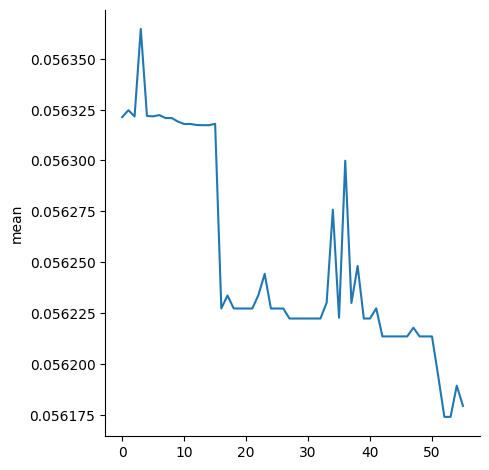

In [86]:
sns.relplot(y=Scoresy['mean'], x=Scoresy.index,kind="line")

In [ ]:
X.info()

In [87]:
best_rmse, best_round, cv_result =  get_scored_m2(X_reduced,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='after_cusotm_filtering',
    best_round=best_round,
    best_rmse=best_rmse
)

Scoresy_m2

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:44:43] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:44:44] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:44:45] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[0]	train-rmse:0.16493+0.00006	test-rmse:0.16493+0.00023
[100]	train-rmse:0.07773+0.00053	test-rmse:0.07801+0.00046
[200]	train-rmse:0.05867+0.00008	test-rmse:0.05922+0.00020
[300]	train-rmse:0.05575+0.00003	test-rmse:0.05643+0.00019
[400]	train-rmse:0.05530+0.00004	test-rmse:0.05605+0.00019
[500]	train-rmse:0.05521+0.00005	test-rmse:0.05599+0.00019
[600]	train-rmse:0.05518+0.00005	test-rmse:0.05597+0.00019
[700]	train-rmse:0.05517+0.00005	test-rmse:0.05597+0.00019
[800]	train-rmse:0.05516+0.00005	test-rmse:0.05597+0.00019
[900]	train-rmse:0.05516+0.00005	test-rmse:0.05597+0.00019
[1000]	train-rmse:0.05516+0.00005	test-rmse:0.05597+0.00019
[1092]	train-rmse:0.05516+0.00005	test-rmse:0.05597+0.00019
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
1039         0.055159        0.000049        0.055968       0.000192
1040         0.055159        0.000049        0.055968       0.000192
1041         0.055159        0.000049        0.055968       0.000192
1042         0.0

,name,best_round,best_rmse
0,before_feature_reduction_experement,645,0.056044
1,after_cusotm_filtering,1043,0.055968


In [88]:
X_toxic = X.copy()
X_toxic.drop(columns=toxic, inplace=True)

In [114]:
Score = get_scored(X_toxic,y)
Scoresy = save_score(Score, Scoresy, 'after_cusotm_filtering_but_neutral included')


RMSE on 5 folds 0.05617454001828447


NameError: name 'Scorsey' is not defined

In [89]:
best_rmse, best_round, cv_result =  get_scored_m2(X_toxic,y)

Scoresy_m2 = add_row(
    Scoresy_m2,
    name='after_cusotm_filtering_but_neutral included',
    best_round=best_round,
    best_rmse=best_rmse
)

Scoresy_m2

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:54:17] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:54:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[0]	train-rmse:0.16494+0.00006	test-rmse:0.16494+0.00023
[100]	train-rmse:0.07745+0.00038	test-rmse:0.07773+0.00035
[200]	train-rmse:0.05857+0.00011	test-rmse:0.05913+0.00010
[300]	train-rmse:0.05572+0.00005	test-rmse:0.05641+0.00016
[400]	train-rmse:0.05529+0.00005	test-rmse:0.05604+0.00018
[500]	train-rmse:0.05520+0.00005	test-rmse:0.05599+0.00018
[600]	train-rmse:0.05516+0.00005	test-rmse:0.05598+0.00018
[700]	train-rmse:0.05515+0.00005	test-rmse:0.05597+0.00019
[800]	train-rmse:0.05515+0.00005	test-rmse:0.05597+0.00019
[900]	train-rmse:0.05514+0.00005	test-rmse:0.05597+0.00019
[1000]	train-rmse:0.05514+0.00005	test-rmse:0.05597+0.00019
[1100]	train-rmse:0.05514+0.00005	test-rmse:0.05597+0.00019
[1200]	train-rmse:0.05514+0.00005	test-rmse:0.05597+0.00019
[1300]	train-rmse:0.05514+0.00005	test-rmse:0.05597+0.00019
[1400]	train-rmse:0.05514+0.00005	test-rmse:0.05597+0.00019
[1500]	train-rmse:0.05514+0.00005	test-rmse:0.05597+0.00019
[1600]	train-rmse:0.05514+0.00005	test-rmse:0.05597+

,name,best_round,best_rmse
0,before_feature_reduction_experement,645,0.056044
1,after_cusotm_filtering,1043,0.055968
2,after_cusotm_filtering_but_neutral included,1705,0.055969


In [115]:
Scoresy.tail()

,experiment_name,0,1,2,3,4,mean,std
52,poped_speed_curvature_ratio_freq,0.056511,0.055753,0.056329,0.056308,0.055969,0.056174,0.000306
53,poped_speed_curvature_ratio_bin5,0.056511,0.055753,0.056329,0.056308,0.055969,0.056174,0.000306
54,poped_speed_curvature_ratio_bin10,0.056538,0.055780,0.056348,0.056308,0.055972,0.056189,0.000306
55,poped_speed_curvature_ratio_bin15,0.056516,0.055760,0.056350,0.056293,0.055977,0.056179,0.000305
56,after_cusotm_filtering_but_neutral included,0.056511,0.055753,0.056329,0.056308,0.055969,0.056174,0.000306


In [ ]:
# Scoresy.head(20).sort_values(by='mean')

In [123]:
Scoresy.style.pipe('make_pretty')

TypeError: 'str' object is not callable

## Strange observation:
16	poped_school_season	            0.056153	0.000267\
18	poped_num_lanes_cat	            0.056155	0.000266\
3	weather_encoded_manual_int		0.056161	0.000269\
1	id_drop	                     	0.056161	0.000279\

So i delete ine by one and checked with OOB XGBRegegressor, so what I found: maybe school season is not good, but i dont get the reason, maybe more clever model can grab it? Still the differance is tiny, so i will leave it as is

So just poping 'id'

## Ok let's try the TARGET ENCODING technique from 'feature engineering' Kaggle mini-course

In [ ]:
X_reduced.info()

In [ ]:
# from category_encoders import MEstimateEncoder



# # Encoding split
# X_y_full = X_reduced.join(y).copy()
# X_encode = X_y_full.sample(frac=0.05, random_state=0)
# y_encode = X_encode.pop("accident_risk")

# # Training split
# X_pretrain = X_y_full.drop(X_encode.index)
# y_train = X_pretrain.pop("accident_risk")
# #
# # Choose a set of features to encode and a value for m
# # encoder = MEstimateEncoder(cols = ['road_type', 'lighting', 'weather', 'curvature', 'speed_limit'], m=20)
# encoder = MEstimateEncoder(cols = ['time_of_day'], m=20)

# # Fit the encoder on the encoding split
# encoder.fit(X_encode, y_encode)

# # Encode the training split
# X_train = encoder.transform(X_pretrain, y_train)

In [ ]:
# Score = get_scored(X_train,y_train)
# Scoresy = save_score(Score, Scoresy, 'target_encoded')
# Scoresy.head(20)

## Ok its going to be worse and worse
## So im going to create complex cat features by merging few

In [ ]:
X


experiment_name	0	1	2	3	4	mean	std\
0	Baseline	            0.057434	0.055794	0.056358	0.056330	0.057250	0.056633	0.000688\
1	id_drop	                0.056413	0.055778	0.056384	0.056270	0.055961	0.056161	0.000279\
2	num_lanes_to_category_copy\
                            0.056380	0.055809	0.056369	0.056288	0.055974	0.056164	0.000258\
3	weather_encoded_manual_int\
                            0.056412	0.055784	0.056361	0.056268	0.055982	0.056161	0.000269\
4	lighting_encoded_manual	0.056442	0.055795	0.056348	0.056253	0.055984	0.056164	0.000268\
5	bool_cats_to_int_exp	0.056442	0.055795	0.056348	0.056253	0.055984	0.056164	0.000268\
6	lanes_speed_lightning_feature\
                            0.056579	0.055964	0.056510	0.056443	0.056117	0.056323	0.000268\
7	speed_curature_ratio	0.056622	0.055945	0.056486	0.056455	0.056096	0.056321	0.000286\
add Codeadd Markdown

## Ok so I guess that's it for now


In [ ]:
# def make_mi_scores(X, y, discrete_features):
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores

# mi_scores = make_mi_scores(X, y, discrete_features)
# mi_scores[::3]  # show a few features with their MI scores

# cols = X.columns.tolist()

# cols

# discrete_mask = discrete_features.loc[cols].to_numpy(dtype=bool)

# discrete_mask

# from sklearn.feature_selection import mutual_info_regression
# mi_scores = mutual_info_regression(X, y,
#                                    discrete_features=discrete_mask,
#                                    random_state=42)
# mi_series = pd.Series(mi_scores, index=cols).sort_values(ascending=False)
# print(mi_series)

In [ ]:
# pip install optuna-integration[xgboost]

In [92]:
import optuna
import xgboost as xgb
# from optuna.integration import XGBoostPruningCallback


dtrain = xgb.DMatrix(X_reduced, label=y, enable_categorical=True)


def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda',
        # 'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'booster': 'gbtree',
        # 'lambda': trial.suggest_float('lambda', 0.0, 10.0, step=0.01),
        # 'alpha': trial.suggest_float('alpha', 0.0, 10.0, step=0.01),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85, step=0.01),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.01),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, step=0.001),
        'max_depth': trial.suggest_int('max_depth', 9, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 4),
        'gamma': trial.suggest_float('gamma', 0.01, 0.02, step=0.001),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.3, 0.5, step=0.01),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.15, step=0.01),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.82, 0.9, step=0.01),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.85, 0.9, step=0.01),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.34, 0.38, step=0.01),
        # 'max_bin': trial.suggest_categorical('max_bin', [256, 512])
        # 'max_bin': 512,
        'random_state': 42,
        'max_delta_step': 1
    }

    # if params['booster'] == 'dart':
    #     params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
    #     params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
    #     params['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.3)
    #     params['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.3)

    # cv adds "test-" prefix automatically
    # pruning_callback = XGBoostPruningCallback(trial, "test-rmse")

    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=3500,
        nfold=5,
        metrics = "rmse",
        stratified=False,
        early_stopping_rounds=50,
        verbose_eval=False,
        # callbacks=[pruning_callback],
    )

    best_rmse = cv_results['test-rmse-mean'].min()
    best_iter = int(cv_results['test-rmse-mean'].idxmin())
    trial.set_user_attr('best_iteration', best_iter)

    return best_rmse

# Настройка Optuna
sampler = optuna.samplers.TPESampler(seed=42)
# sampler = optuna.samplers.CmaEsSampler(seed=42)
# pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=30, interval_steps=10)
study = optuna.create_study(direction='minimize', sampler=sampler, study_name='xgb_cv_opt',
                           storage="sqlite:///optuna_xgb_TPESampler3.db", load_if_exists=True)
study.optimize(objective, n_trials=50, timeout=2000000, show_progress_bar=True,)

# Сохраняем результаты
study.trials_dataframe().to_csv("optuna_xgb_cv_trials.csv", index=False)
print(f"Best params: {study.best_params}")
print(f"Best RMSE: {study.best_value:.5f}")
print(f"Best iteration: {study.best_trial.user_attrs['best_iteration']}")

[I 2025-10-31 12:04:33,716] A new study created in RDB with name: xgb_cv_opt


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:04:35] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:04:36] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:07:53,448] Trial 0 finished with value: 0.055971074534817124 and parameters: {'colsample_bytree': 0.79, 'subsample': 0.98, 'learning_rate': 0.025, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.011, 'reg_lambda': 0.31, 'reg_alpha': 0.15, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.89, 'scale_pos_weight': 0.34}. Best is trial 0 with value: 0.055971074534817124.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:07:54] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:07:55] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:13:56,165] Trial 1 finished with value: 0.0559729965335176 and parameters: {'colsample_bytree': 0.85, 'subsample': 0.94, 'learning_rate': 0.014, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.013000000000000001, 'reg_lambda': 0.41, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.84, 'colsample_bynode': 0.88, 'scale_pos_weight': 0.34}. Best is trial 0 with value: 0.055971074534817124.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:13:57] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:13:58] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:17:28,990] Trial 2 finished with value: 0.05597146398348525 and parameters: {'colsample_bytree': 0.78, 'subsample': 0.75, 'learning_rate': 0.019000000000000003, 'max_depth': 12, 'min_child_weight': 2, 'gamma': 0.015, 'reg_lambda': 0.42, 'reg_alpha': 0.1, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.34}. Best is trial 0 with value: 0.055971074534817124.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:17:30] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:17:31] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:20:29,851] Trial 3 finished with value: 0.055973028054209076 and parameters: {'colsample_bytree': 0.85, 'subsample': 0.99, 'learning_rate': 0.026000000000000002, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.017, 'reg_lambda': 0.39, 'reg_alpha': 0.1, 'colsample_bylevel': 0.86, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 0 with value: 0.055971074534817124.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:20:30] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:20:31] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:20:32] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:24:23,777] Trial 4 finished with value: 0.055964147321143375 and parameters: {'colsample_bytree': 0.77, 'subsample': 0.87, 'learning_rate': 0.016, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.5, 'reg_alpha': 0.14, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.9, 'scale_pos_weight': 0.36000000000000004}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:24:24] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:24:25] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:24:26] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:34:18,222] Trial 5 finished with value: 0.05597843386956699 and parameters: {'colsample_bytree': 0.85, 'subsample': 0.63, 'learning_rate': 0.014, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.014, 'reg_lambda': 0.35, 'reg_alpha': 0.14, 'colsample_bylevel': 0.85, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.36000000000000004}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:34:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:34:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:42:22,551] Trial 6 finished with value: 0.05597121326496929 and parameters: {'colsample_bytree': 0.76, 'subsample': 0.9199999999999999, 'learning_rate': 0.011, 'max_depth': 12, 'min_child_weight': 4, 'gamma': 0.012, 'reg_lambda': 0.3, 'reg_alpha': 0.14, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.89, 'scale_pos_weight': 0.37}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:42:23] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:42:24] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:42:25] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:50:56,598] Trial 7 finished with value: 0.05597049491880886 and parameters: {'colsample_bytree': 0.75, 'subsample': 0.74, 'learning_rate': 0.012, 'max_depth': 12, 'min_child_weight': 3, 'gamma': 0.013000000000000001, 'reg_lambda': 0.31, 'reg_alpha': 0.11, 'colsample_bylevel': 0.84, 'colsample_bynode': 0.89, 'scale_pos_weight': 0.37}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:50:57] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:50:58] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:50:59] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 12:58:28,212] Trial 8 finished with value: 0.055964681626827384 and parameters: {'colsample_bytree': 0.84, 'subsample': 0.79, 'learning_rate': 0.012, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.016, 'reg_lambda': 0.45999999999999996, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.86, 'colsample_bynode': 0.87, 'scale_pos_weight': 0.34}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:58:29] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:58:30] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:02:20,572] Trial 9 finished with value: 0.0559960270552345 and parameters: {'colsample_bytree': 0.76, 'subsample': 0.61, 'learning_rate': 0.023, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.019000000000000003, 'reg_lambda': 0.35, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.34}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:02:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:02:22] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:02:23] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:05:52,445] Trial 10 finished with value: 0.05597345992266376 and parameters: {'colsample_bytree': 0.8200000000000001, 'subsample': 0.88, 'learning_rate': 0.03, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.01, 'reg_lambda': 0.5, 'reg_alpha': 0.14, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.9, 'scale_pos_weight': 0.36000000000000004}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:05:53] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:05:54] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:05:55] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:10:59,668] Trial 11 finished with value: 0.055975693695684406 and parameters: {'colsample_bytree': 0.8200000000000001, 'subsample': 0.83, 'learning_rate': 0.018000000000000002, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.017, 'reg_lambda': 0.5, 'reg_alpha': 0.13, 'colsample_bylevel': 0.82, 'colsample_bynode': 0.87, 'scale_pos_weight': 0.35000000000000003}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:11:00] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:11:01] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:11:02] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:17:28,804] Trial 12 finished with value: 0.05597025843596422 and parameters: {'colsample_bytree': 0.81, 'subsample': 0.8099999999999999, 'learning_rate': 0.016, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.017, 'reg_lambda': 0.45999999999999996, 'reg_alpha': 0.13, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.88, 'scale_pos_weight': 0.35000000000000003}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:17:29] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:17:30] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:17:31] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:25:17,093] Trial 13 finished with value: 0.0559878608293228 and parameters: {'colsample_bytree': 0.78, 'subsample': 0.72, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.02, 'reg_lambda': 0.45999999999999996, 'reg_alpha': 0.15, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.9, 'scale_pos_weight': 0.35000000000000003}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:25:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:25:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:29:10,363] Trial 14 finished with value: 0.05596821752680413 and parameters: {'colsample_bytree': 0.83, 'subsample': 0.87, 'learning_rate': 0.020999999999999998, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.015, 'reg_lambda': 0.45999999999999996, 'reg_alpha': 0.11, 'colsample_bylevel': 0.82, 'colsample_bynode': 0.87, 'scale_pos_weight': 0.37}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:29:11] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:29:12] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:33:33,235] Trial 15 finished with value: 0.05596672271669549 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.01, 'reg_lambda': 0.48, 'reg_alpha': 0.13, 'colsample_bylevel': 0.86, 'colsample_bynode': 0.88, 'scale_pos_weight': 0.36000000000000004}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:33:34] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:33:35] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:41:21,453] Trial 16 finished with value: 0.05597113166658021 and parameters: {'colsample_bytree': 0.77, 'subsample': 0.78, 'learning_rate': 0.013000000000000001, 'max_depth': 12, 'min_child_weight': 4, 'gamma': 0.016, 'reg_lambda': 0.44999999999999996, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.84, 'colsample_bynode': 0.87, 'scale_pos_weight': 0.35000000000000003}. Best is trial 4 with value: 0.055964147321143375.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:41:23] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:41:24] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:46:19,611] Trial 17 finished with value: 0.05596263168695548 and parameters: {'colsample_bytree': 0.83, 'subsample': 0.85, 'learning_rate': 0.016, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.43, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:46:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:46:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:46:22] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:51:36,695] Trial 18 finished with value: 0.055964276727853604 and parameters: {'colsample_bytree': 0.81, 'subsample': 0.86, 'learning_rate': 0.017, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.43, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:51:37] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:51:38] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:51:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 13:55:35,557] Trial 19 finished with value: 0.05596975645251576 and parameters: {'colsample_bytree': 0.79, 'subsample': 0.9299999999999999, 'learning_rate': 0.020999999999999998, 'max_depth': 12, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.38, 'reg_alpha': 0.14, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.9, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:55:36] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:55:37] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:00:17,696] Trial 20 finished with value: 0.055969408976187573 and parameters: {'colsample_bytree': 0.75, 'subsample': 0.8999999999999999, 'learning_rate': 0.015, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.011, 'reg_lambda': 0.37, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:00:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:00:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:05:18,073] Trial 21 finished with value: 0.05596685140994988 and parameters: {'colsample_bytree': 0.81, 'subsample': 0.85, 'learning_rate': 0.018000000000000002, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.013000000000000001, 'reg_lambda': 0.43, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:05:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:05:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:10:30,531] Trial 22 finished with value: 0.05597008020960724 and parameters: {'colsample_bytree': 0.83, 'subsample': 0.84, 'learning_rate': 0.016, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.44, 'reg_alpha': 0.1, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:10:31] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:10:32] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:10:33] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:14:15,516] Trial 23 finished with value: 0.05596272007235896 and parameters: {'colsample_bytree': 0.81, 'subsample': 0.88, 'learning_rate': 0.018000000000000002, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.011, 'reg_lambda': 0.48, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:14:16] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:14:17] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:14:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:17:56,905] Trial 24 finished with value: 0.055969329396706215 and parameters: {'colsample_bytree': 0.83, 'subsample': 0.95, 'learning_rate': 0.02, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.011, 'reg_lambda': 0.48, 'reg_alpha': 0.1, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:17:58] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:17:59] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:21:19,062] Trial 25 finished with value: 0.055968387653223074 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8899999999999999, 'learning_rate': 0.023, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.014, 'reg_lambda': 0.48, 'reg_alpha': 0.13, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:21:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:21:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:25:35,045] Trial 26 finished with value: 0.05596918346808309 and parameters: {'colsample_bytree': 0.8200000000000001, 'subsample': 0.82, 'learning_rate': 0.018000000000000002, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.01, 'reg_lambda': 0.49, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:25:36] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:25:37] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:30:52,914] Trial 27 finished with value: 0.055965905906476474 and parameters: {'colsample_bytree': 0.79, 'subsample': 0.78, 'learning_rate': 0.014, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.011, 'reg_lambda': 0.48, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.36000000000000004}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:30:54] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:30:55] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:34:18,149] Trial 28 finished with value: 0.055979121368058604 and parameters: {'colsample_bytree': 0.84, 'subsample': 0.9099999999999999, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.014, 'reg_lambda': 0.4, 'reg_alpha': 0.15, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.89, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:34:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:34:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:39:11,824] Trial 29 finished with value: 0.055969418012368474 and parameters: {'colsample_bytree': 0.78, 'subsample': 0.95, 'learning_rate': 0.022, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.013000000000000001, 'reg_lambda': 0.5, 'reg_alpha': 0.15, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.88, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:39:13] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:39:14] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:42:04,741] Trial 30 finished with value: 0.05597276515398131 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.97, 'learning_rate': 0.025, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.011, 'reg_lambda': 0.44, 'reg_alpha': 0.1, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.87, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:42:05] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:42:06] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:42:07] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:46:11,686] Trial 31 finished with value: 0.05596648056312155 and parameters: {'colsample_bytree': 0.81, 'subsample': 0.86, 'learning_rate': 0.017, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.42, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:46:12] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:46:13] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:46:14] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:50:59,395] Trial 32 finished with value: 0.055968840482839524 and parameters: {'colsample_bytree': 0.81, 'subsample': 0.87, 'learning_rate': 0.017, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.47, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:51:00] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:51:01] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:55:44,385] Trial 33 finished with value: 0.05596654168629571 and parameters: {'colsample_bytree': 0.8200000000000001, 'subsample': 0.84, 'learning_rate': 0.015, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.013000000000000001, 'reg_lambda': 0.41, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:55:45] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:55:46] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 14:59:19,411] Trial 34 finished with value: 0.055967259063345376 and parameters: {'colsample_bytree': 0.84, 'subsample': 0.8999999999999999, 'learning_rate': 0.019000000000000003, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.01, 'reg_lambda': 0.44, 'reg_alpha': 0.1, 'colsample_bylevel': 0.8899999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:59:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [14:59:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:04:08,720] Trial 35 finished with value: 0.05596732397471778 and parameters: {'colsample_bytree': 0.79, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 0.011, 'reg_lambda': 0.42, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:04:09] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:04:10] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:04:11] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:08:57,627] Trial 36 finished with value: 0.05596410048638717 and parameters: {'colsample_bytree': 0.78, 'subsample': 0.76, 'learning_rate': 0.019000000000000003, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.012, 'reg_lambda': 0.4, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:08:58] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:08:59] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:14:25,321] Trial 37 finished with value: 0.05597355050729619 and parameters: {'colsample_bytree': 0.77, 'subsample': 0.6699999999999999, 'learning_rate': 0.019000000000000003, 'max_depth': 12, 'min_child_weight': 2, 'gamma': 0.014, 'reg_lambda': 0.39, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.36000000000000004}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:14:26] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:14:27] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:20:17,431] Trial 38 finished with value: 0.05596516881433916 and parameters: {'colsample_bytree': 0.77, 'subsample': 0.75, 'learning_rate': 0.014, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.013000000000000001, 'reg_lambda': 0.36, 'reg_alpha': 0.13, 'colsample_bylevel': 0.85, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:20:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:20:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:26:18,846] Trial 39 finished with value: 0.05597161816063789 and parameters: {'colsample_bytree': 0.76, 'subsample': 0.75, 'learning_rate': 0.013000000000000001, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.01, 'reg_lambda': 0.32999999999999996, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.89, 'scale_pos_weight': 0.36000000000000004}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:26:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:26:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:26:21] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:29:33,327] Trial 40 finished with value: 0.05596895737154649 and parameters: {'colsample_bytree': 0.78, 'subsample': 0.78, 'learning_rate': 0.024, 'max_depth': 12, 'min_child_weight': 2, 'gamma': 0.014, 'reg_lambda': 0.4, 'reg_alpha': 0.14, 'colsample_bylevel': 0.86, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:29:34] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:29:35] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:34:17,576] Trial 41 finished with value: 0.05596323226882571 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.82, 'learning_rate': 0.017, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.012, 'reg_lambda': 0.43, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:34:18] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:34:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:34:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:38:06,223] Trial 42 finished with value: 0.055967066289840495 and parameters: {'colsample_bytree': 0.77, 'subsample': 0.83, 'learning_rate': 0.018000000000000002, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.012, 'reg_lambda': 0.41, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:38:07] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:38:08] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:40:48,272] Trial 43 finished with value: 0.05597514914813721 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.76, 'learning_rate': 0.028000000000000004, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.011, 'reg_lambda': 0.39, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:40:49] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:40:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:44:18,259] Trial 44 finished with value: 0.05596659761284546 and parameters: {'colsample_bytree': 0.78, 'subsample': 0.8099999999999999, 'learning_rate': 0.019000000000000003, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.012, 'reg_lambda': 0.49, 'reg_alpha': 0.1, 'colsample_bylevel': 0.87, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:44:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:44:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:49:18,041] Trial 45 finished with value: 0.055971066608514065 and parameters: {'colsample_bytree': 0.76, 'subsample': 0.88, 'learning_rate': 0.016, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.013000000000000001, 'reg_lambda': 0.44999999999999996, 'reg_alpha': 0.11, 'colsample_bylevel': 0.86, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:49:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:49:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:53:49,181] Trial 46 finished with value: 0.05596629903579894 and parameters: {'colsample_bytree': 0.79, 'subsample': 0.9199999999999999, 'learning_rate': 0.020999999999999998, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 0.011, 'reg_lambda': 0.42, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.83, 'colsample_bynode': 0.88, 'scale_pos_weight': 0.36000000000000004}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:53:50] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:53:51] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 15:57:55,142] Trial 47 finished with value: 0.05596891292133055 and parameters: {'colsample_bytree': 0.85, 'subsample': 0.71, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.013000000000000001, 'reg_lambda': 0.47, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.9, 'scale_pos_weight': 0.38}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:57:56] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [15:57:57] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 16:04:17,893] Trial 48 finished with value: 0.05598407259820324 and parameters: {'colsample_bytree': 0.76, 'subsample': 0.73, 'learning_rate': 0.017, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.018000000000000002, 'reg_lambda': 0.49, 'reg_alpha': 0.13, 'colsample_bylevel': 0.85, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.35000000000000003}. Best is trial 17 with value: 0.05596263168695548.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:04:19] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [16:04:20] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  a list of expected value.


[I 2025-10-31 16:12:42,042] Trial 49 finished with value: 0.05598351061839457 and parameters: {'colsample_bytree': 0.78, 'subsample': 0.82, 'learning_rate': 0.012, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 0.015, 'reg_lambda': 0.44999999999999996, 'reg_alpha': 0.12000000000000001, 'colsample_bylevel': 0.8999999999999999, 'colsample_bynode': 0.86, 'scale_pos_weight': 0.37}. Best is trial 17 with value: 0.05596263168695548.
Best params: {'colsample_bytree': 0.83, 'subsample': 0.85, 'learning_rate': 0.016, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.43, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}
Best RMSE: 0.05596
Best iteration: 1224


In [94]:
study.best_params)

{'colsample_bytree': 0.83, 'subsample': 0.85, 'learning_rate': 0.016, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.43, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}


In [102]:
study.best_trial.user_attrs['best_iteration']

1224

{'colsample_bytree': 0.83, 'subsample': 0.85, 'learning_rate': 0.016, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 0.012, 'reg_lambda': 0.43, 'reg_alpha': 0.11, 'colsample_bylevel': 0.8799999999999999, 'colsample_bynode': 0.85, 'scale_pos_weight': 0.38}

n_estimators = 1224 + 10



/tmp/ipykernel_37/1958398855.py:9: ExperimentalWarning:

optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



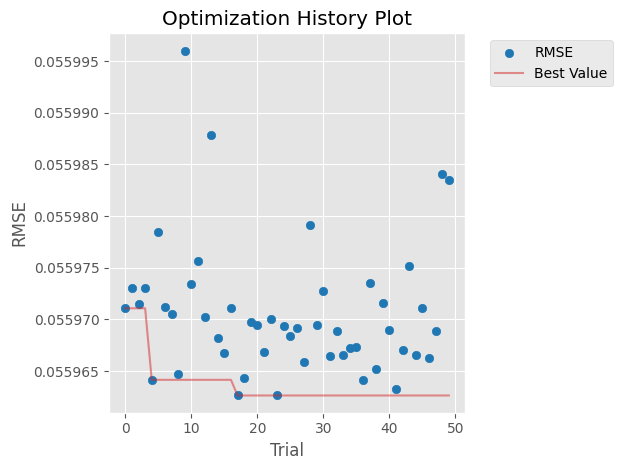

ImportError: Tried to import 'sklearn.base' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: cannot import name '_fit_context' from 'sklearn.base' (/usr/local/lib/python3.11/dist-packages/sklearn/base.py).

In [117]:
# import matplotlib.pyplot as plt

# # После optimize(...)
# # График истории оптимизации
# fig = optuna.visualization.plot_optimization_history(study)
# fig.show()

# # Или, если хотите использование matplotlib (альтернативный вариант)
# ax = optuna.visualization.matplotlib.plot_optimization_history(
#     study,
#     target_name='RMSE'
# )
# plt.tight_layout()
# plt.show()

# # Дополнительно: важность параметров
# fig_imp = optuna.visualization.plot_param_importances(study)
# fig_imp.show()


In [ ]:
## XGBoost for submission

In [ ]:
parametrs = {'max_depth': 12,
 'n_estimators': 629,            
 'learning_rate': 0.012979250475635971,
 'subsample': 0.9707429033714928,
 'colsample_bytree': 0.9147427767339446,
 'colsample_bylevel': 0.8346988683782983,
 'reg_alpha': 0.014884815777159114,
 'reg_lambda': 2.9658416401715585e-05,
 'min_child_weight': 7,
 'gamma': 8.548894020869924e-06,
 'max_leaves': 121,
 'random_state': 42,
 'enable_categorical':True}

In [ ]:
test_ids = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')


In [ ]:
XGB_model = XGBRegressor(**parametrs)
XGB_model.fit(X,y)
pred = XGB_model.predict(X_test)

In [ ]:
submission = pd.DataFrame({
    'id': test_ids['id'],
    'accident_risk': pred
})

# Save submission
submission.to_csv("submission.csv", index=False)

on mine  X dataframe Best round: 1999, Best CV RMSE: 0.0559972\
on his df            Best round: 1340, Best CV RMSE: 0.0559564\
mine X               Best round: 966,  Best CV RMSE: 0.0560125